# Assess the quality of L1000 imputation using genetic perturbation consensus signatures

In [1]:
import pandas
import numpy
import matplotlib.pyplot
import seaborn

%matplotlib inline

## Read genes

In [2]:
gene_df = pandas.read_table('data/consensi/genes.tsv')
gene_df.head(2)

,entrez_gene_id,status,symbol,type_of_gene,description
0,100,imputed,ADA,protein-coding,adenosine deaminase
1,1000,imputed,CDH2,protein-coding,"cadherin 2, type 1, N-cadherin (neuronal)"


## Read consensus signatures

In [3]:
def get_tidied(path):
    """Read a dataframe of consensus signatures. Convert from matrix format to a tidy dataframe."""
    df = pandas.read_table(path)
    df = pandas.melt(df, id_vars='perturbagen', var_name='entrez_gene_id', value_name='z_score')
    for col in ['perturbagen', 'entrez_gene_id']:
        df[col] = df[col].astype(int)
    df = df.merge(gene_df[['entrez_gene_id', 'status']])
    df['z_score_ihs'] = numpy.arcsinh(df['z_score'])
    return df

In [4]:
kd_df = get_tidied('data/consensi/consensi-knockdown.tsv.bz2')
oe_df = get_tidied('data/consensi/consensi-overexpression.tsv.bz2')

kd_df['pert_type'] = 'knockdown'
oe_df['pert_type'] = 'overexpression'

dysreg_df = pandas.concat([kd_df, oe_df])

In [5]:
dysreg_df.head(2)

,perturbagen,entrez_gene_id,z_score,status,z_score_ihs,pert_type
0,2,100,-0.047,imputed,-0.046983,knockdown
1,9,100,-1.218,imputed,-1.027446,knockdown


## Perturbation-with-self z-scores 

In [6]:
self_df = dysreg_df.query("perturbagen == entrez_gene_id").copy()
self_df['direction'] = self_df.z_score.map(lambda x: 'down' if x < 0 else 'up')

In [7]:
seaborn.set(style='whitegrid')
seaborn.set_style({'figure.figsize': (6, 3.7)})

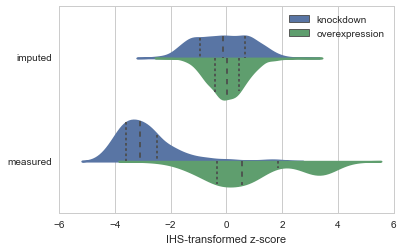

In [8]:
ax = seaborn.violinplot(x='z_score_ihs', y='status', data=self_df, inner='quartile', hue='pert_type', split=True)
text = ax.set_xlabel("IHS-transformed z-score")
text = ax.set_ylabel('')
ax.legend_.set_title('')
matplotlib.pyplot.savefig('viz/self-targeting-perts.png', bbox_inches='tight', cut=0, dpi=300)

In [9]:
pandas.crosstab(self_df.status, self_df.pert_type, margins=True)

pert_type,knockdown,overexpression,All
status,,,
imputed,2068,1108,3176
measured,960,486,1446
All,3028,1594,4622


In [10]:
# Percent of perts that upregulate their target
percent_df = 100 * self_df.groupby(['pert_type', 'status']).apply(lambda df: (df.z_score > 0).mean())
percent_df.name = 'percent_up'
percent_df = percent_df.reset_index()
percent_df

,pert_type,status,percent_up
0,knockdown,imputed,45.647969
1,knockdown,measured,2.916667
2,overexpression,imputed,50.722022
3,overexpression,measured,63.991770


## Significant genes for knockdowns

In [11]:
kd_sig_df = pandas.read_table('data/consensi/signif/dysreg-knockdown.tsv')
kd_sig_df.status.value_counts()

measured    175879
imputed     152189
Name: status, dtype: int64

In [12]:
self_df = kd_sig_df.query("perturbagen == entrez_gene_id")
pandas.crosstab(self_df.status, self_df.direction, margins=True)

direction,down,up,All
status,,,
imputed,16,8,24
measured,790,1,791
All,806,9,815


## Significant genes for overexpressions

In [13]:
oe_sig_df = pandas.read_table('data/consensi/signif/dysreg-overexpression.tsv')
oe_sig_df.status.value_counts()

measured    24333
imputed     16309
Name: status, dtype: int64

In [14]:
self_df = oe_sig_df.query("perturbagen == entrez_gene_id")
pandas.crosstab(self_df.status, self_df.direction, margins=True)

direction,down,up,All
status,,,
imputed,1,4,5
measured,3,120,123
All,4,124,128
